# Calibration overview


An image of the sky contains counts from several sources. The task of data
reduction (another name for image calibration) is to remove all non-celestial
counts from the image and to correct for non-uniform sensitivity.

At the end of the previous notebook we arrived at an expression for the counts
in a science image in terms of the sources of counts:

$$
\text{raw image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars}).
$$

Solving for the counts just from the stars is as follows:

$$
\text{stars} + \text{noise} = \frac{\text{raw image} - \text{bias} - \text{dark current}}{\text{flat}} - \text{sky}
$$

**It is *impossible* to remove the noise from the raw image because the noise is
random.**

The dark current is typically calculated from a *dark frame* (aka dark image).
Such an image has bias and read noise in it as well, so:

$$
\text{dark current} + \text{noise} = (\text{dark frame} - \text{bias})/(\text{dark exposure time})
$$

Once again, note that the noise cannot be removed.

## This noise cannot be removed from CCD images

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R48){:target="_blank"}

To demonstrate that you cannot remove the noise from an image, let's construct
an image with just stars and noise and try to subtract a noise image created
with the same parameters. The amount of noise here is exaggerated to make it
clear in the images.

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from astropy.visualization import hist
from astropy.stats import histogram

import image_sim as imsim
from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

### First, some stars with noise

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R87){:target="_blank"}

The image below shows stars (the larger "blobs" in the image) but shows quite a
bit of noise as well (the much smaller "dots").

Text(0.5, 1.0, 'Stars with noise')

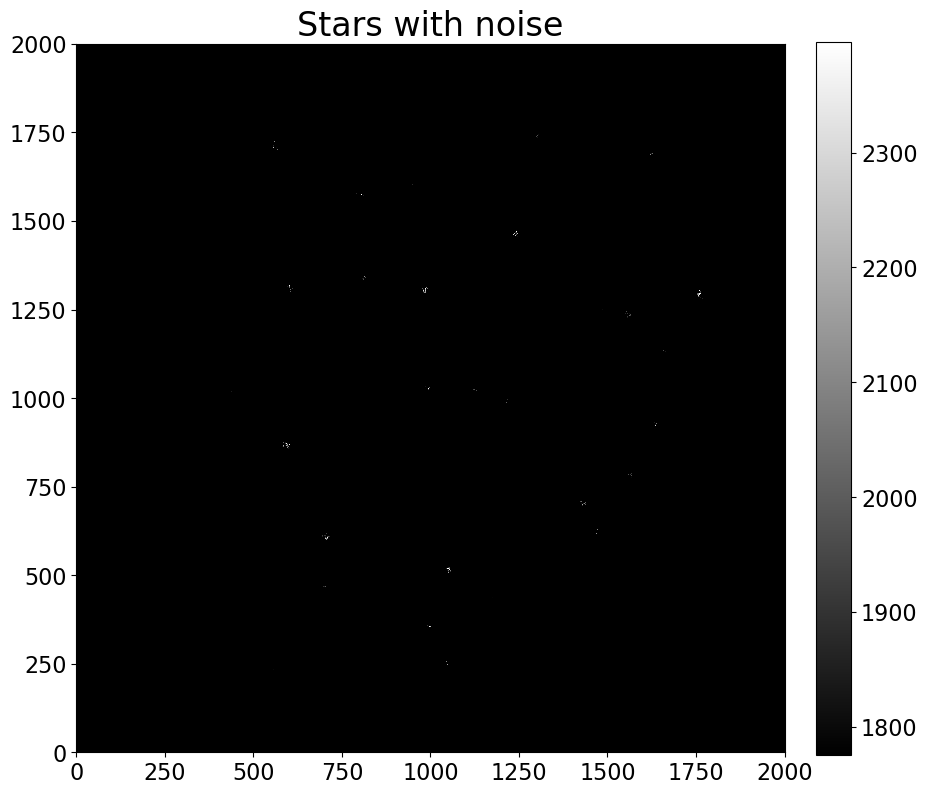

In [3]:
image = np.zeros([2000, 2000])
gain = 1.0
noise_amount = 1500 

stars_with_noise = imsim.stars(image, 50, max_counts=2000, fwhm=10) + imsim.read_noise(image, noise_amount, gain=gain)

show_image(stars_with_noise, cmap='gray', percu=99.9)
plt.title('Stars with noise')

### Now an *incorrect* attempt at reducing noise

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R113){:target="_blank"}

Notice that the call to the noise function has exactly the same arguments as
above, in much the same way your camera's electronics will have the same noise
properties every time you read out an image.

However, the amount of noise has **increased**, not decreased. It's much harder
to pick out the stars in this image.

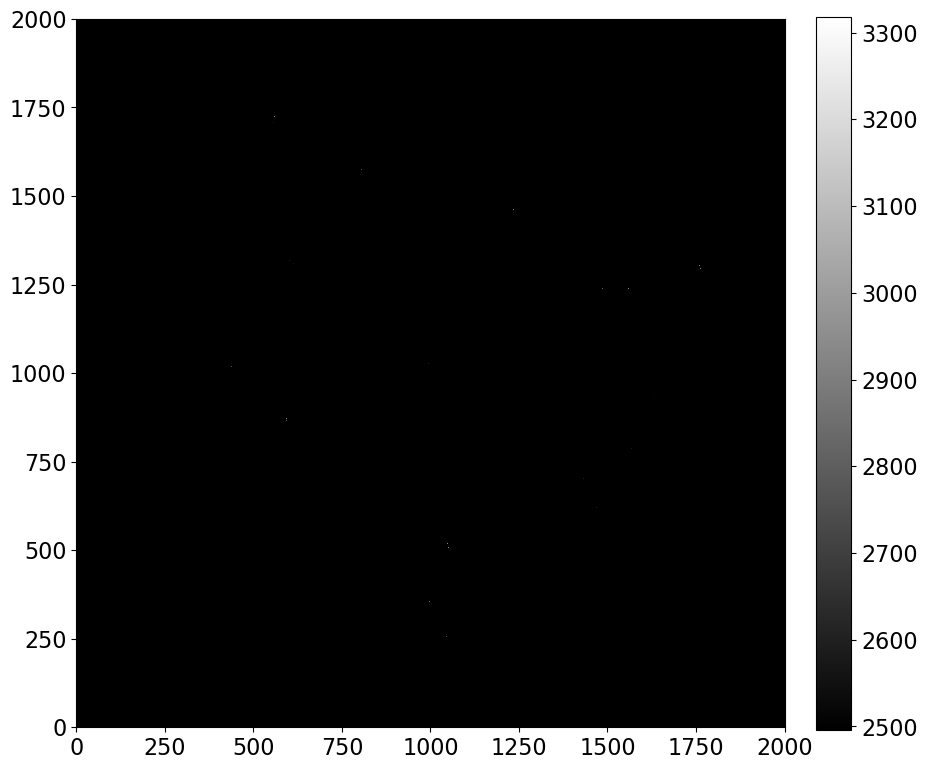

In [4]:
incorrect_attempt_to_remove_noise = stars_with_noise - imsim.read_noise(image, noise_amount, gain=gain)

show_image(incorrect_attempt_to_remove_noise, cmap='gray', percu=99.9)

## Every image has noise

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R138){:target="_blank"}

Every image, including calibration images like bias and dark frames, has noise.
If we tried to calibrate images by taking a single bias image and a single dark
image, the final result might well look worse than before the image is reduced.

For demonstration, we'll see what happens below.

Note that here we construct *realistic* bias and dark, but leave read noise out
of the flat; we'll return to that point later.

### First, set parameters for the CCD

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R154){:target="_blank"}

These are the same as in the previous notebook, except for the read noise, which
is 700$e-$, 100 times larger than in the previous notebook.

In [5]:
gain = 1.0
star_exposure = 30.0
dark_exposure = 60.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise_electrons = 700
max_star_counts = 2000

### Generate the images, with noise

In [6]:
bias_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                   imsim.read_noise(image, read_noise_electrons, gain=gain))

dark_frame_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                         imsim.dark_current(image, dark, dark_exposure, gain=gain, hot_pixels=True) +
                         imsim.read_noise(image, read_noise_electrons, gain=gain))

flat = imsim.sensitivity_variations(image)

/Users/mattcraig/development/ccd-reduction-and-photometry-guide/notebooks/image_sim.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
        Use RickerWavelet2D instead. [image_sim]


In [7]:
realistic_stars = (imsim.stars(image, 50, max_counts=max_star_counts) +
                   imsim.dark_current(image, dark, star_exposure, gain=gain, hot_pixels=True) +
                   imsim.bias(image, bias_level, realistic=True) +
                   imsim.read_noise(image, read_noise_electrons, gain=gain)
                  )

/Users/mcraig/Documents/Research/find-file-links-ccd-redu-phot/ccd-reduction-and-photometry-guide/notebooks/image_sim.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain


### Uncalibrated image

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R216){:target="_blank"}

Below we display the uncalibrated image; in a moment we'll compare it to the
calibrated version. Even though they don't stand out there really are stars in
it.

<Figure size 1200x1200 with 0 Axes>

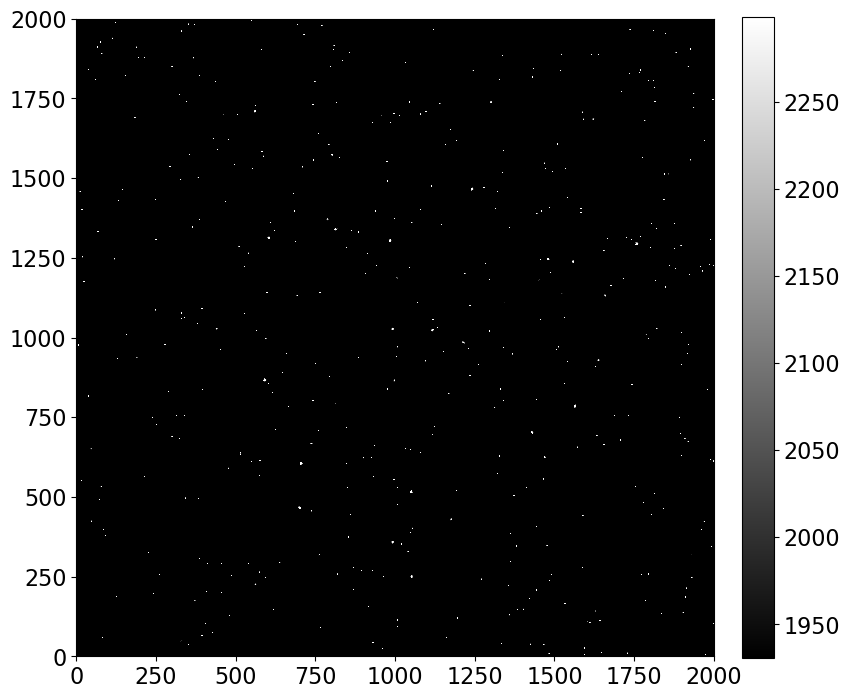

In [8]:
plt.figure(figsize=(12, 12))
show_image(realistic_stars, cmap='gray', percu=99.9, figsize=(9, 9))

### Reduce (calibrate) the star image

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R237){:target="_blank"}

First we calculate the dark current, scaled to the exposure time of our light
image.

In [9]:
scaled_dark_current = star_exposure * (dark_frame_with_noise - bias_with_noise) / dark_exposure

Next, we subtract the bias and dark current from the star image and then apply
the flat correction.

In [10]:
calibrated_stars = (realistic_stars - bias_with_noise - scaled_dark_current) / flat

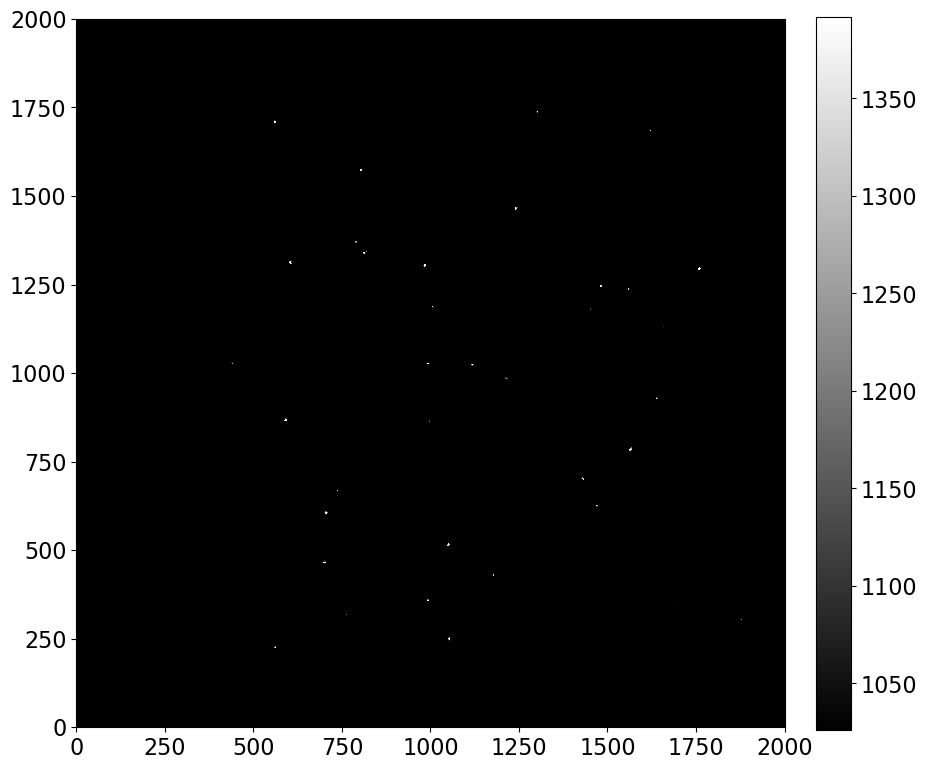

In [11]:
show_image(calibrated_stars, cmap='gray', percu=99.9)

### Reducing the image cleans up the image a bit

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R282){:target="_blank"}

The stars stand more clearly than in the unreduced image.

This image does not look *much* better than the uncalibrated image, but remember
that the read noise used in this simulated image, 700 $e^-$ per pixel, is
unrealistically high.

### Reducing the image increases the noise in the image

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/218/files#diff-e68335d91ecff166e2afcee832511ee2R295){:target="_blank"}

The histogram below shows pixel values before and after calibration. The width
of the distribution is a measure of the read noise. As expected, reducing the
image increases the read noise. One reason one takes several calibration images
of each type is to reduce the amount of noise in the calibration image. That
will, in turn, keep the noise in the final image as small as possible.

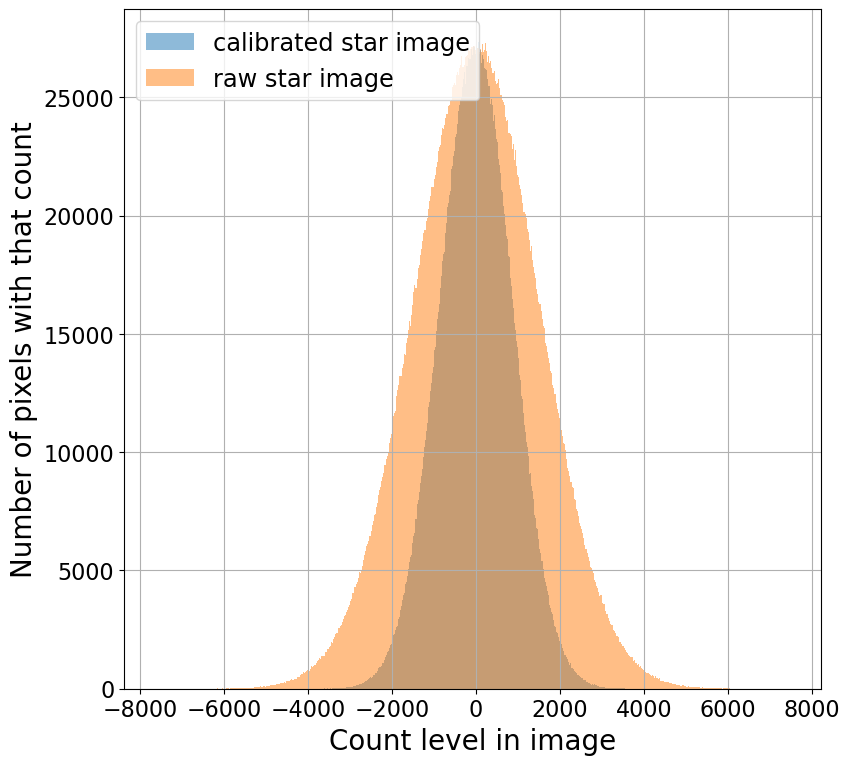

In [12]:
plt.figure(figsize=(9, 9))
hist(calibrated_stars.flatten(), bins='freedman', label='calibrated star image', alpha=0.5)
hist(stars_with_noise.flatten(), bins='freedman', label='raw star image', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('Count level in image')
plt.ylabel('Number of pixels with that count');